In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
class field():
    def __init__(self, ncells, bctype, bcs = np.array([0.0,0.0])):
        self.nghost = 2 #Per side
        self.ncells = ncells
        self.cc = np.zeros(ncells + 2*self.nghost)
        self.derivative = np.zeros(ncells + 2*self.nghost)
        self.cfVals_left = np.zeros(ncells+1)
        self.cfVals_right = np.zeros(ncells+1)
        self.a = np.zeros(ncells+1)
        self.bc = bctype
        self.bcDirichlet = bcs
        
    def setInitCond(self, f, vals):
        self.cc[self.nghost:-self.nghost] = f(vals)
        self.setGhostCellValues()
        
    def computeDerivative(self, dx, theta = 1.0):
        self.derivative[1:-1] =  (1.0/dx)*minmod((theta)*(self.cc[1:-1] - self.cc[0:-2]), \
                                  (0.5)*(self.cc[2:] - self.cc[:-2]), \
                                  (theta)*(self.cc[2:] - self.cc[1:-1]))
        
    '''def updateStuff(self):
        self.cc[0+int(0.5*self.nghost):-1*int(0.5*self.nghost)] = self.ccVals
        if (self.bc == 'periodic'):
            #self.setGhostCellValues(np.array([self.cc[1], self.cc[-2]]))
            self.cc[0] = self.cc[-2]
            self.cc[-1] = self.cc[1]
        #else:
        #    pass
    '''
        
    def setGhostCellValues(self):
        if (self.bc == 'periodic'):
            #print('Calling periodic BC')
            self.cc[:self.nghost] = self.cc[-2*self.nghost:-self.nghost]
            self.cc[-self.nghost:] = self.cc[self.nghost:2*self.nghost]
        elif (self.bc == 'dirichlet'):
            #print('Calling Dirichlet BC')
        #We will have problems if there are really strong gradients close to the boundary!
            self.cc[:self.nghost] = self.bcDirichlet[0]
            self.cc[-self.nghost:] = self.bcDirichlet[1]
        elif (self.bc == 'infiniteDomain'):
            #Has to be defined more mathematically
            raise ValueError('Under construction.....')
                
        else:
            raise ValueError('Unknown boundary condition')

    def computeCellFaceValues(self, dx):
        self.computeDerivative(dx)
        self.cfVals_left[:] = self.cc[self.nghost-1:-self.nghost] + \
            0.5*dx*self.derivative[self.nghost-1:-self.nghost]
        self.cfVals_right[:] = self.cc[self.nghost:-self.nghost+1] - \
            0.5*dx*self.derivative[self.nghost:-self.nghost+1]
        
    def computeFluxes(self, dx, fluxFn, fder):
        self.computeCellFaceValues(dx)
        
        self.a = computeLocalSpeed(self, fder)
        
        self.flux_jphalf = 0.5*(fluxFn(self.cfVals_right[1:]) + fluxFn(self.cfVals_left[1:]) \
                                - self.a[1:]*(self.cfVals_right[1:] - self.cfVals_left[1:]))
        
        self.flux_jmhalf = 0.5*(fluxFn(self.cfVals_right[:-1]) + fluxFn(self.cfVals_left[:-1]) \
                                - self.a[:-1]*(self.cfVals_right[:-1] - self.cfVals_left[:-1]))
        self.FinalFlux = -(self.flux_jphalf - self.flux_jmhalf)/dx
        
    def advance(self, dt):
        self.cc[self.nghost:-self.nghost] = \
            self.cc[self.nghost:-self.nghost] + dt * self.FinalFlux
        self.setGhostCellValues()
        
    
    def get_cc(self):
            return self.cc[self.nghost:-self.nghost]
        
        
#------------------------------------------------------------------------------------------
class domain:
    def __init__(self, ncells, endpts):
        self.ncells = ncells
        self.xLeft = endpts[0]
        self.xRight = endpts[1]
        self.dx = (self.xRight - self.xLeft)/self.ncells
        self.x_cc = np.linspace(self.xLeft+0.5*self.dx, self.xRight-0.5*self.dx, ncells)
#-------------------------------------------------------------------------------------------
                
#-------------------------------------------------------------------------------------------
def minmod(a, b, c):
    result = np.zeros(len(a))
    overall = np.array([a, b, c])
    signs = np.prod(np.sign(overall),0)
    result[signs > 0] = np.amax(overall[:, signs > 0], 0)
    result[signs < 0] = np.amin(overall[:, signs < 0], 0)
    return result   
#-------------------------------------------------------------------------------------------
def computeLocalSpeed(u_field, fder):
    #This changes if the above function changes
    return np.amax(np.absolute(np.array([fder(u_field.cfVals_left), fder(u_field.cfVals_right)])),0)

##  Zero flux fn

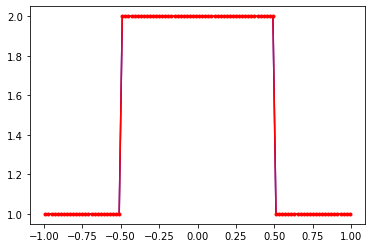

In [35]:
#Domain setup
x = domain(100, np.array([-1,1]))
fluxFn = lambda u: np.zeros(u.shape)
fluxFnDer = lambda u: np.zeros(u.shape)

#Field setup
u = field(x.ncells, 'periodic')
utemp = field(x.ncells, 'periodic')

#Initial conditions
initC = lambda x: 1.0*(x < 0.5) + 1.0*(x > -0.5)
u.setInitCond(initC, x.x_cc)

plt.figure()
t = 0.0
tFinal = 1.0
dt = 0.1
n_steps = int(np.ceil(tFinal/dt))
plt.plot(x.x_cc, initC(x.x_cc),'b')
for i in range(n_steps):
    old_cc = np.copy(u.cc)
    #Two step
    u.computeFluxes(x.dx, fluxFn, fluxFnDer)
    u.advance(dt)
    
    u.computeFluxes(x.dx, fluxFn, fluxFnDer)
    u.advance(dt)
    
    u.cc = 0.5*(old_cc + u.cc)
    t = t + dt
ccVals = u.get_cc()
plt.plot(x.x_cc, ccVals,'r.-')#, x,uLxF[1:-1],'g*')
plt.show()

## Simple advection

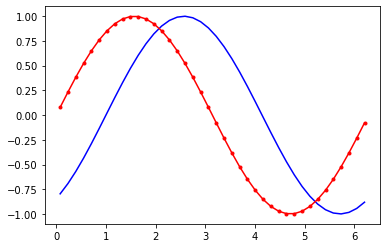

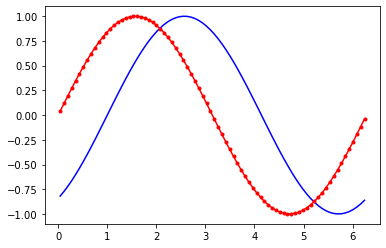

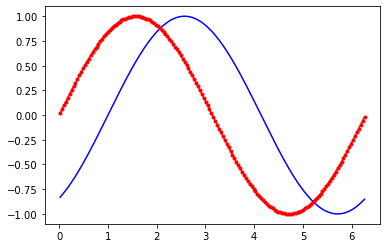

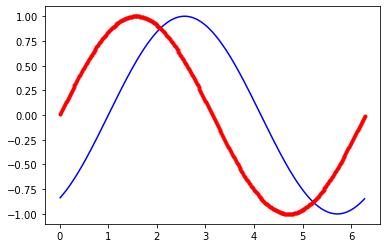

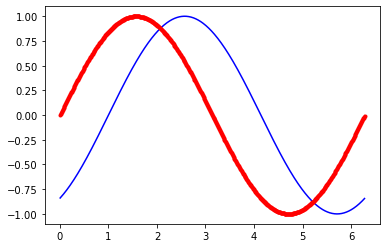

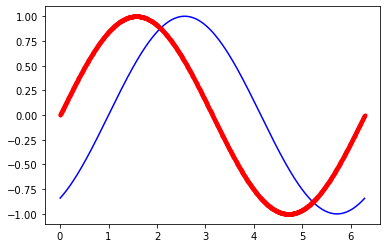

Slope:  -0.00010811062316197505


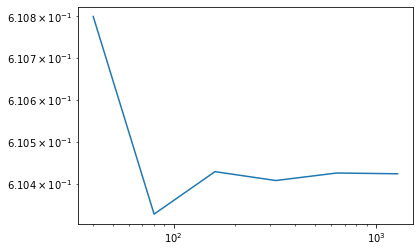

In [132]:
#Domain setup
def simple_advection(Ncells, CFL):
    x = domain(Ncells, np.array([0,2*np.pi]))
    fluxFn = lambda u: -u
    fluxFnDer = lambda u: -1.0*np.ones(u.shape)

    #Field setup
    u = field(x.ncells, 'periodic')

    #Initial conditions
    initC = lambda x: np.sin(x)
    u.setInitCond(initC, x.x_cc)
    
    plt.figure()
    t = 0.0
    tFinal = 1.0
    dt = CFL * x.dx/np.amax(fluxFnDer(initC(x.x_cc)))
    n_steps = int(np.ceil(tFinal/dt))
    dt = tFinal / n_steps
    n_steps = int(np.ceil(tFinal/dt))
    plt.plot(x.x_cc, initC(x.x_cc - tFinal),'b')
    for i in range(n_steps):
        old_cc = np.copy(u.cc)
        #Two step
        u.computeFluxes(x.dx, fluxFn, fluxFnDer)
        u.advance(dt)
        
        u.computeFluxes(x.dx, fluxFn, fluxFnDer)
        u.advance(dt)
        
        u.cc = 0.5*(old_cc + u.cc)
        t = t + dt
    ccVals = u.get_cc()
    plt.plot(x.x_cc, ccVals,'r.-')
    plt.show()
    return (np.linalg.norm(initC(x.x_cc + tFinal) - ccVals, 1)/Ncells)
Nx = np.array([40, 80, 160, 320, 640, 1280])
errors = [simple_advection(n, 0.5) for n in Nx]
interpolation = np.polyfit(np.log2(Nx), np.log2(errors),1)
print('Slope: ', interpolation[0])
plt.loglog(Nx, errors)
plt.show()
#print(errors)
#orderSlope = np.log2(np.diff(1./Nx))/np.log2(abs(np.diff(errors)))
#orderSlope

## Burgers equation (How do I get the exact solution?- not the expansiony expression)

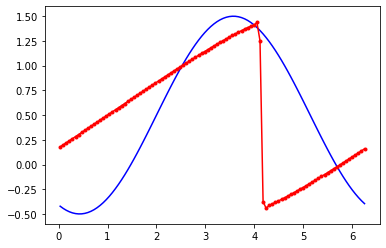

In [87]:
def burgers(Ncells, CFL):
    #Domain setup
    x = domain(100, np.array([0.0,2.0*np.pi]))
    fluxFn = lambda u: 0.5*u**2
    fluxFnDer = lambda u: u

    #Field setup
    u = field(x.ncells, 'periodic')

    #Initial conditions
    initC = lambda x: 0.5 + np.sin(x)
    u.setInitCond(initC, x.x_cc)

    plt.figure()
    t = 0.0
    tFinal = 2.0
    CFL = 0.5
    dt = CFL * x.dx/np.amax(fluxFnDer(initC(x.x_cc)))
    n_steps = int(np.ceil(tFinal/dt))
    dt = tFinal / n_steps
    n_steps = int(np.ceil(tFinal/dt))
    plt.plot(x.x_cc, initC(x.x_cc- tFinal),'b')
    for i in range(n_steps):
        old_cc = np.copy(u.cc)
        #Two step
        u.computeFluxes(x.dx, fluxFn, fluxFnDer)
        u.advance(dt)

        u.computeFluxes(x.dx, fluxFn, fluxFnDer)
        u.advance(dt)

        u.cc = 0.5*(old_cc + u.cc)
        t = t + dt
    ccVals = u.get_cc()
    plt.plot(x.x_cc, ccVals,'r.-')
    plt.show()
burgers(40, 0.2)
#Nx = np.array([40, 80, 160, 320, 640, 1280])
#errors = [burgers(n, 0.5) for n in Nx]
#interpolation = np.polyfit(np.log2(Nx), np.log2(errors),1)
#print('Slope: ', interpolation[0])
#plt.loglog(Nx, errors)
#plt.show()

## Non-convex flux

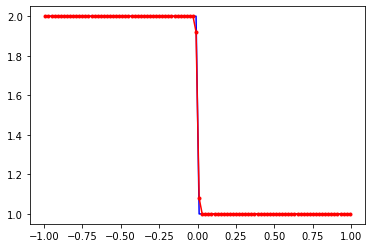

In [120]:
#Domain setup
def nonConvexFlux(Ncells, CFL):
    x = domain(Ncells, np.array([-1.0, 1.0]))
    fluxFn = lambda u: 0.25*((u**2 - 1.0)*(u**2 - 4.0))
    fluxFnDer = lambda u: 0.5*u*(2*u**2 - 5.0)

    #Field setup
    boundaryConditions = np.array([2.0, 1.0])
    u = field(x.ncells,'dirichlet', boundaryConditions)

    #Initial conditions
    initC = lambda x: boundaryConditions[0]*(x < 0.01) + (boundaryConditions[1]*(x > 0.0))
    u.setInitCond(initC, x.x_cc)

    plt.figure()
    t = 0.0
    tFinal = 1.0
    dt = CFL * x.dx/np.amax(fluxFnDer(initC(x.x_cc)))
    n_steps = int(np.ceil(tFinal/dt))
    dt = tFinal / n_steps
    n_steps = int(np.ceil(tFinal/dt))
    plt.plot(x.x_cc, initC(x.x_cc),'b')
    for i in range(n_steps):
        #print(t)
        
        old_cc = np.copy(u.cc)
        #Two step
        u.computeFluxes(x.dx, fluxFn, fluxFnDer)
        u.advance(dt)

        u.computeFluxes(x.dx, fluxFn, fluxFnDer)
        u.advance(dt)

        u.cc = 0.5*(old_cc + u.cc)
        t = t + dt
        ccVals = u.get_cc()
        break
    plt.plot(x.x_cc, ccVals,'r.-')
    plt.show()
nonConvexFlux(100, 0.5)
#Nx = np.array([40, 80, 160, 320, 640, 1280])
#errors = [nonConvexFlux(n, 0.2) for n in Nx]
#interpolation = np.polyfit(np.log2(Nx), np.log2(errors),1)
#print('Slope: ', interpolation[0])
#plt.loglog(Nx, errors)
#plt.show()

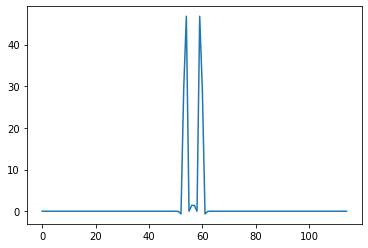

In [122]:
plt.plot(u.a[1:]*(u.cfVals_right[1:] - u.cfVals_left[1:]))

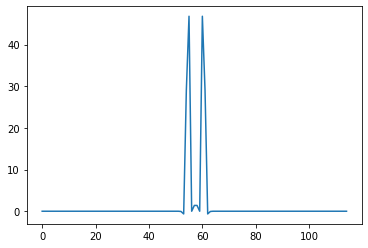

In [123]:
plt.plot(u.a[:-1]*(u.cfVals_right[:-1] - u.cfVals_left[:-1]))